In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis  # Import skewness and kurtosis functions
from scipy.stats import t


In [24]:

# Define the input and output directories
input_directory = 'D:/Position_ABM/'
output_directory = 'D:/'

def get_mod(v):
    return np.sqrt(v.dot(v))

def get_step_vector(index, data_x, data_y, data_z):
    dx = data_x[index] - data_x[index - 1]
    dy = data_y[index] - data_y[index - 1]
    dz = data_z[index] - data_z[index - 1]
    step_vector = np.array([dx, dy, dz])
    return step_vector

def get_ct(x_data, y_data, z_data):
    length = len(x_data)
    step_vectors = np.empty((length - 1, 3))
    cos_theta_temp = np.empty(length - 2)
    for i in np.arange(length):
        if i >= 1:
            step_vectors[i - 1] = get_step_vector(i, x_data, y_data, z_data)
        if i >= 2:
            v0 = step_vectors[i - 2]
            v1 = step_vectors[i - 1]
            mod_v0 = get_mod(v0)
            mod_v1 = get_mod(v1)
            
            # Check if the magnitudes are non-zero before calculating the cosine
            if mod_v0 > 0 and mod_v1 > 0:
                cos_theta_temp[i - 2] = np.dot(v0, v1) / (mod_v1 * mod_v0)
            else:
                cos_theta_temp[i - 2] = np.nan  # Handle the case where one of the magnitudes is zero
    return cos_theta_temp

# Create a DataFrame to store the statistics
statistics_df = pd.DataFrame(columns=['File', 'Average', 'Mean +/-', 'Standard Deviation', 'SD +/-', 'Skewness', 'Kurtosis'])

# Get a list of all CSV files in the input directory
csv_files = [f for f in os.listdir(input_directory) if f.endswith('.csv')]

# Define the tab10 color palette
colors = plt.cm.tab10.colors

# Loop through each CSV file
for csv_file in csv_files:
    # Construct the full path for the input CSV file
    input_file_path = os.path.join(input_directory, csv_file)
    
    # Read the CSV file, skipping the first 3 rows
    df = pd.read_csv(input_file_path)#, skiprows=2)
    
    # Extract the file name from the input file path
    input_file_name = os.path.basename(input_file_path)
    output_file_name = os.path.splitext(input_file_name)[0] + 'all'#'_average_cos_theta_histogram.png'

    # Sort the DataFrame by 'TrackID' and 'Time'
    df.sort_values(by=['TrackID', 'Time'], inplace=True)

    # Split the DataFrame by 'TrackID'
    unique_track_ids = df['TrackID'].unique()

    # Create a dictionary to store cos(theta) arrays for each Track ID
    cos_theta_dict = {}

    for track_id in unique_track_ids:
        track_data = df[df['TrackID'] == track_id]
        x_data = track_data['Position X'].values
        y_data = track_data['Position Y'].values
        z_data = track_data['Position Z'].values

        cos_theta_track = get_ct(x_data, y_data, z_data)
        
        # Check if the cos_theta_track is not empty before storing
        if len(cos_theta_track) > 0:
            cos_theta_dict[track_id] = cos_theta_track

    # Calculate the average cos(theta) for each Track ID and store it in a dictionary
    avg_cos_theta_dict = {}
    for track_id, cos_theta_values in cos_theta_dict.items():
        avg_cos_theta = np.nanmean(cos_theta_values)  # Use np.nanmean to handle NaN values
        avg_cos_theta_dict[track_id] = avg_cos_theta

    # Create a histogram for the average cos(theta) values
    avg_cos_theta_values = list(avg_cos_theta_dict.values())
    
    # Check if the file name contains 'PVDRN' or 'PVRCA' and set the histogram color accordingly
    if 'PVDRN' in input_file_name:
        color = colors[1]  # Orange
    elif 'PVRCA' in input_file_name:
        color = colors[2]  # Green
    elif 'dnpvr' in input_file_name:
        color = colors[1]
    else:
        #color = colors[0]  # Blue (Default color if neither 'PVDRN' nor 'PVRCA' is in the file name)
        color = "maroon"
    plt.hist(avg_cos_theta_values, bins=30, density=True, alpha=0.5, color=color)
    plt.xlabel('Average Cos(theta)')
    plt.xlim(-1, 1)
    plt.ylim(0, 3)
    plt.ylabel('Probability density')

    # Calculate and store statistics in the DataFrame
    avg = np.nanmean(avg_cos_theta_values)  # Use np.nanmean to handle NaN values
    std_dev = np.nanstd(avg_cos_theta_values)  # Use np.nanstd to handle NaN values
    skewness = skew(avg_cos_theta_values)
    kurt = kurtosis(avg_cos_theta_values)
    
    # Calculate the sample size
    sample_size = len(avg_cos_theta_values)

    # Calculate the standard error of the mean (SEM)
    sem = std_dev / np.sqrt(sample_size)

    # Calculate the 95% confidence interval for the mean as +/- value
    confidence_interval_mean = 1.96 * sem
    
    # Calculate the degrees of freedom
    df = sample_size - 1

    # Calculate the t-statistic for a 95% confidence level
    t_stat = t.ppf(0.975, df)

    # Calculate the confidence interval for the standard deviation
    ci_lower = std_dev - t_stat * std_dev / np.sqrt(df)
    ci_upper = std_dev + t_stat * std_dev / np.sqrt(df)
    # Calculate the standard deviation error bar
    sd_error_bar = ci_upper - std_dev

    
    new_row = {
        'File': input_file_name,
        'Average': avg,
        'Mean +/-': confidence_interval_mean,
        'Standard Deviation': std_dev,
        'SD +/-': sd_error_bar,
        'Skewness': skewness,
        'Kurtosis': kurt
    }

    statistics_df = pd.concat([statistics_df, pd.DataFrame([new_row])], ignore_index=True)

    # Define the output file path in the 'F:/ang/' directory
    output_file_path = os.path.join(output_directory, output_file_name)
    
    # Save the histogram as an image in the 'F:/ang/' directory
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

# Print the DataFrame containing statistics
print(statistics_df)

# Save the DataFrame to a CSV file
statistics_df.to_csv('D:\statisticsABM.csv', index=False)

<>:154: SyntaxWarning: invalid escape sequence '\s'
<>:154: SyntaxWarning: invalid escape sequence '\s'
C:\Users\JACOB-ASMAT\AppData\Local\Temp\ipykernel_19624\983749003.py:154: SyntaxWarning: invalid escape sequence '\s'
  statistics_df.to_csv('D:\statisticsABM.csv', index=False)
C:\Users\JACOB-ASMAT\AppData\Local\Temp\ipykernel_19624\983749003.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics_df = pd.concat([statistics_df, pd.DataFrame([new_row])], ignore_index=True)


               File   Average  Mean +/-  Standard Deviation    SD +/-  \
0  ABM24_H05_75.csv  0.023336  0.008038            0.041013  0.008179   
1      ABM_H025.csv -0.250235  0.007982            0.040725  0.008121   
2       ABM_H05.csv  0.001316  0.007355            0.037526  0.007484   
3      ABM_H075.csv  0.330172  0.009779            0.049895  0.009950   

   Skewness  Kurtosis  
0 -0.331975  0.375317  
1  0.065896 -0.814201  
2 -0.087450  0.087590  
3  0.199831  0.205305  


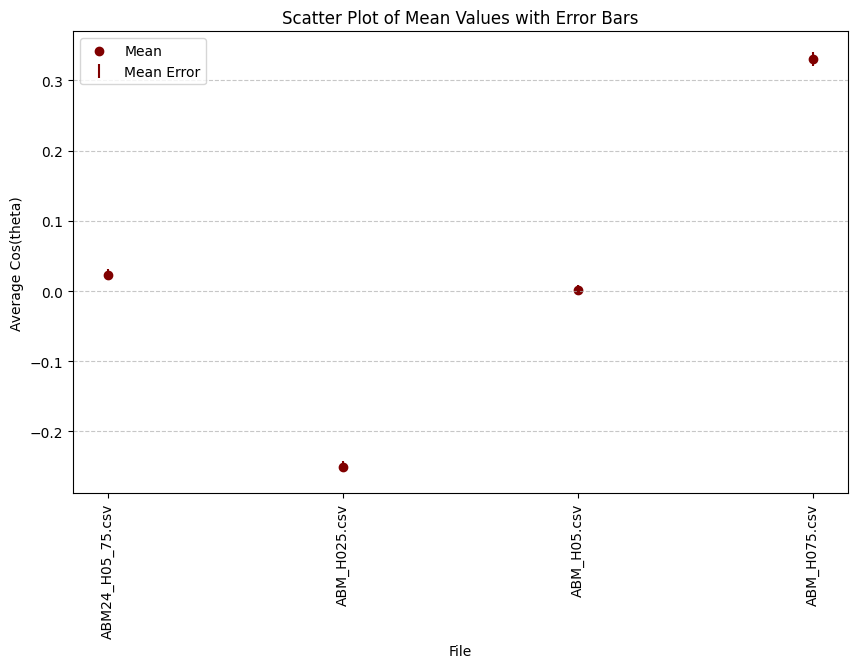

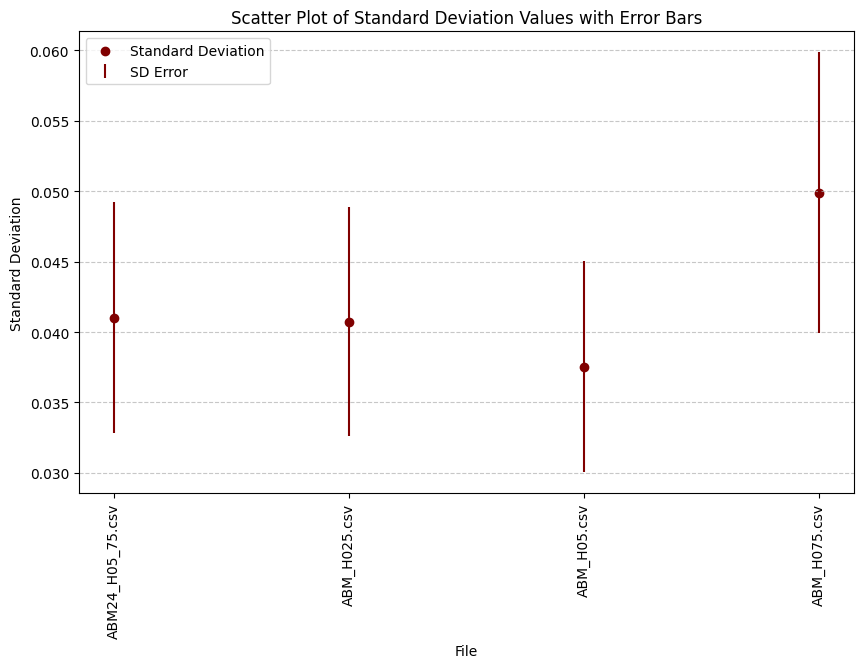

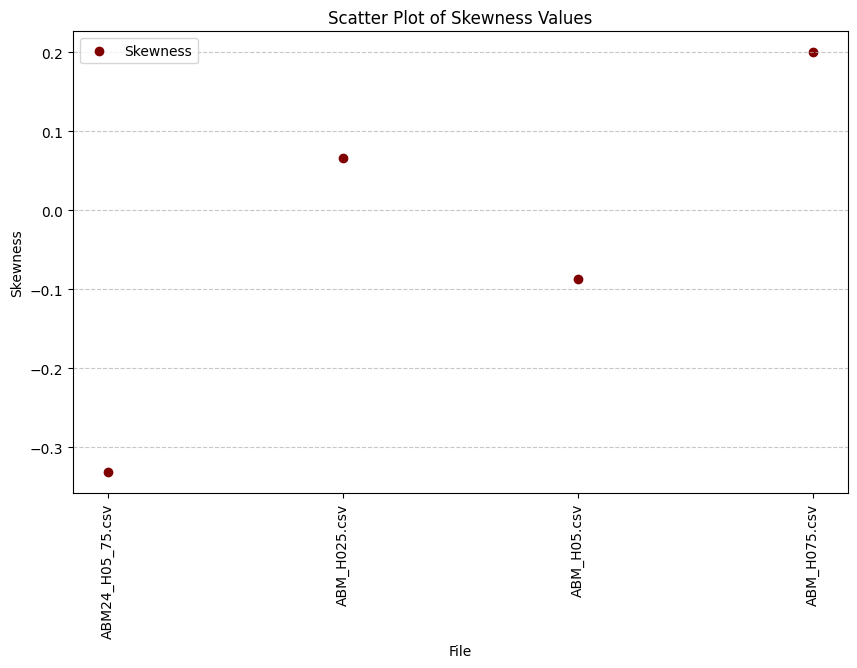

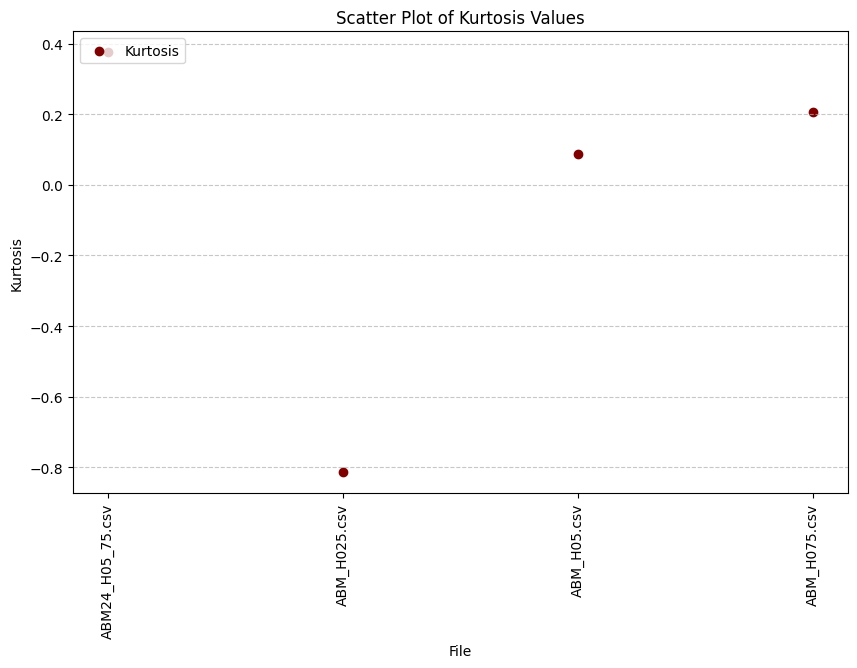

In [25]:



# Create a list of dictionaries with the data to be added
new_rows = []

for file_name in statistics_df['File']:
    color = ''
    if 'PVDRN' in file_name or 'dnpvr' in file_name:
        color = 'orange'
    elif 'PVRCA' in file_name:
        color = 'green'
    else:
        color = 'maroon'

    new_rows.append({
        'File': file_name,
        'Color': color
    })

# Concatenate the original DataFrame with the new DataFrame created from the list of dictionaries
colors_df = pd.concat([statistics_df, pd.DataFrame(new_rows)], ignore_index=True, axis=1)

# Scatter plot for the Mean values with error bars
plt.figure(figsize=(10, 6))
scatter = plt.scatter(statistics_df['File'], statistics_df['Average'], c='maroon', label='Mean')
errorbar = plt.errorbar(statistics_df['File'], statistics_df['Average'], yerr=statistics_df['Mean +/-'], fmt='none', color='maroon', ecolor='maroon')
plt.xlabel('File')
plt.ylabel('Average Cos(theta)')
plt.title('Scatter Plot of Mean Values with Error Bars')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([scatter, errorbar], ['Mean', 'Mean Error'], loc='upper left')



# Save the scatter plot as an image
mean_scatter_plot_path = os.path.join(output_directory, 'mean_scatter_plot.png')
plt.savefig(mean_scatter_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Scatter plot for the Standard Deviation values with error bars
plt.figure(figsize=(10, 6))
scatter = plt.scatter(statistics_df['File'], statistics_df['Standard Deviation'], c='maroon', label='Standard Deviation')
errorbar = plt.errorbar(statistics_df['File'], statistics_df['Standard Deviation'], yerr=statistics_df['SD +/-'], fmt='none', color='maroon', ecolor='maroon')
plt.xlabel('File')
plt.ylabel('Standard Deviation')
plt.title('Scatter Plot of Standard Deviation Values with Error Bars')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([scatter, errorbar], ['Standard Deviation', 'SD Error'], loc='upper left')

# Save the scatter plot as an image
std_dev_scatter_plot_path = os.path.join(output_directory, 'std_dev_scatter_plot.png')
plt.savefig(std_dev_scatter_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Scatter plot for Skewness values
plt.figure(figsize=(10, 6))
scatter = plt.scatter(statistics_df['File'], statistics_df['Skewness'], c='maroon', label='Skewness')
plt.xlabel('File')
plt.ylabel('Skewness')
plt.title('Scatter Plot of Skewness Values')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([scatter], ['Skewness'], loc='upper left')

# Save the scatter plot as an image
skewness_scatter_plot_path = os.path.join(output_directory, 'skewness_scatter_plot.png')
plt.savefig(skewness_scatter_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Scatter plot for Kurtosis values
plt.figure(figsize=(10, 6))
scatter = plt.scatter(statistics_df['File'], statistics_df['Kurtosis'], c='maroon', label='Kurtosis')
plt.xlabel('File')
plt.ylabel('Kurtosis')
plt.title('Scatter Plot of Kurtosis Values')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([scatter], ['Kurtosis'], loc='upper left')

# Save the scatter plot as an image
kurtosis_scatter_plot_path = os.path.join(output_directory, 'kurtosis_scatter_plot.png')
plt.savefig(kurtosis_scatter_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
